# A convolutional autoencoder in PyTorch

**[Faisal Z. Qureshi](http://vclab.science.uoit.ca)**  

Check out excellent PyTorch tutorials by "SherlockLiao" at [https://github.com/L1aoXingyu/pytorch-beginner](https://github.com/L1aoXingyu/pytorch-beginner)

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

## See if have cuda support

In [2]:
for i in range(torch.cuda.device_count()):
    print("Found device:", torch.cuda.get_device_name(i))

if torch.cuda.device_count() == 0:
    print("No GPU device found")
else:
    print("Current cuda device is", torch.cuda.get_device_name(torch.cuda.current_device()))

No GPU device found


## Set up dataset

In [3]:
batch_size = 16

my_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('../datasets', transform=my_transforms, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

## A Variational Autoencoder

### `reparametrize(self, mu, logvar)`

`logvar` = $\log \sigma^2$    
`mu` = $\mu$

$$
\begin{eqnarray}
\sigma & = & \exp \left( \frac{1}{2} \log \sigma^2 \right) \\
& = & \exp \left( \log \sigma^{2 ^ \frac{1}{2}} \right) \\
& = & \exp \log \sigma \\
& = & \sigma
\end{eqnarray}
$$

How to generate a random from normal distribution with mean $\mu$ and variance $\sigma^2$?

1. Generate $x \sim \mathcal{N}(0,1)$.
2. Compute $y = \sigma x + \mu$.  Here $y \sim \mathcal{N}(\mu,\sigma^2)$  


In [5]:
class var_autoencoder(nn.Module):
    def __init__(self):
        super(var_autoencoder, self).__init__()

        self.fc1 = nn.Linear(784, 400)       # These layers will be used for encoding 
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)        # These layers will be used for decoding
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))             # h1 is 400-dimensional vector
        return self.fc21(h1), self.fc22(h1)  # this returns two 20-dimensional vectors

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)         # Latent variable z is 20-dimensional 

    def decode(self, z):
        h3 = F.relu(self.fc3(z))             # z can be used to generate new samples
        return F.sigmoid(self.fc4(h3))       # remember that z ~ N(mu, var)

    def forward(self, x):                    
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

Now we train

In [6]:
if torch.cuda.is_available():
    model = var_autoencoder().cuda() # Lets put this on Cuda
else:
    model = var_autoencoder()

In [7]:
learning_rate = 1e-2
weight_decay = 1e-5

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [8]:
num_epochs = 1

for epoch in range(num_epochs):
    
    for data in dataloader:        
        img, _ = data # img is a [batch_size, num_channels, 28, 28] tensor
                      # here num_channels is 1
        
        img = img.view(img.size(0), -1) # We resize it to [batchsize, 1x28x28] tensor
        
        if torch.cuda.is_available():
            img = Variable(img).cuda() # Lets put this on Cuda
        else:
            img = Variable(img)

        output, mu, logvar = model(img) # Forward
        loss = criterion(output, img)

        optimizer.zero_grad() # Backward & update weights
        loss.backward()
        optimizer.step()
        
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data.item()))
    if epoch % 1 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, 'image-vae-{}.png'.format(epoch))

/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch [1/1], loss:0.9230


## Saving the trained model

Now that training is done, it is a good idea to save the trained model.

We are interested in state_dict dictionary that contains parameters associated with each layer in the model.  Optimizer too has a state_dict.

In [9]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, " -- " , model.state_dict()[param_tensor].size())

Model's state_dict:
fc1.weight  --  torch.Size([400, 784])
fc1.bias  --  torch.Size([400])
fc21.weight  --  torch.Size([20, 400])
fc21.bias  --  torch.Size([20])
fc22.weight  --  torch.Size([20, 400])
fc22.bias  --  torch.Size([20])
fc3.weight  --  torch.Size([400, 20])
fc3.bias  --  torch.Size([400])
fc4.weight  --  torch.Size([784, 400])
fc4.bias  --  torch.Size([784])


In [10]:
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name)
    #print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state
param_groups


In [11]:
#torch.save(model.state_dict(), 'conv-ae-weights.pt')

## Inference

Now lets pass an image through the learned model and see what we get

torch.Size([1, 28, 28]) 0


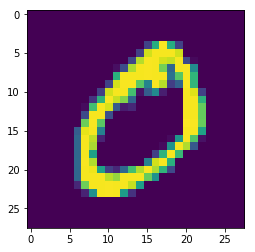

In [16]:
image, label = dataset[1]
print(image.shape, label)

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(image[0])

torch.Size([1, 784]) torch.Size([1, 20]) torch.Size([1, 20])


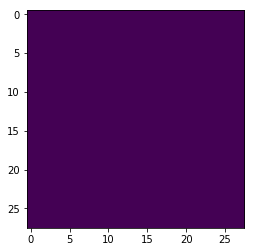

In [32]:
ni = (image - 0.5)/0.5
ni = ni.view(28*28).unsqueeze_(0)
a, b, c = model(ni)
print(a.shape, b.shape, c.shape)
oi_ = to_img(a.view(1,1,28,28))
plt.imshow(oi_[0,0,:,:].detach())

## Loading the saved model

We can easily load the model as follows

In [33]:
if torch.cuda.is_available():
    model2 = autoencoder().cuda() # Lets put this on Cuda
else:
    model2 = autoencoder()

NameError: name 'autoencoder' is not defined

The following should produce garbage, since we haven't trained the model yet

In [ ]:
oi = model2(ni)
#print(oi.shape)
oi_ = to_img(oi)
#print(oi_.shape)

plt.imshow(oi_[0,0,:,:].detach())

Now lets load the model and see what happens

In [ ]:
model2.load_state_dict(torch.load('conv-ae-weights.pt'))
oi = model2(ni)
#print(oi.shape)
oi_ = to_img(oi)
#print(oi_.shape)

plt.imshow(oi_[0,0,:,:].detach())

Notice that when you load the model all is well in the world of autoencoders

## Using part of the trained network
​
Now lets assume we are interested in the encoder bit only.  I.e., we want to pass an MNIST image and wants to get its 3-dimensional encoding.  We can do it as follows.

In [ ]:
class my_encoder(nn.Module):
    def __init__(self):
        super(my_encoder, self).__init__()
        
        self.features = nn.Sequential(*list(model2.encoder.children())[:])
    
    def forward(self, x):
        x = self.features(x)
        return x

In [ ]:
encoder = my_encoder()
encoding = encoder(ni)
print(encoding.shape)